# Observing increase in damage done by Wildfires in Greece - from browsing to coding

### Introduction

The Copernicus Data Space Ecosystem supports learning programming for Earth Observation data analysis in series of incremental steps. This notebook takes you from viewing satellite imagery and experimenting with different visualizations through understanding API requests in a  graphical interface, to writing and editing your own code in Jupyter Notebooks.

### Where to start - our use case

In our example, we want to analyse the effects of wildfires. Wildfires are becoming more frequent in the wake of climate change, and Earth observation offers far-reaching possibilities for identifying wildfires and quantifying their impact. 
For this, first we will first look into spectral indices that highlight vegetation fires and burnt areas, then we will find ways to download raster map data of burnt areas, and finally, we will calculate the extent of burnt area the JupyterLab to visualise changes over time.

## Step 1: Copernicus Browser

To get first impression of what wildfires look like on Sentinel-2 imagery, take a look at the extensive forest fires in Canada [here](https://link.dataspace.copernicus.eu/shk) - the link will take you directly to the same scene as the image below, in the Copernicus Browser.

![True Color Sentinel-2 image of Wildfires near Lac de la Frégate, Quebec, Canada ](./img/copernicus_browser_canada_wildfire.jpg)

You can experiment with different visualizations in the layer list in the sidebar. Which one provides the most intuitive view of the fire activity? Probably the [SWIR visualisation](https://link.dataspace.copernicus.eu/sl6), which is based on bands B12, B8A and B4. It shows the thermal activity of the fire and partly avoids the obscuring effect of the smoke. 

![SWIR composite Sentinel-2 image of wildfires near Lac de la Frégate, Quebec, Canada ](./img/copernicus_browser_canada_wildfire_swir.jpg)

It is also possible to create new custom visualisations using the Browser's composite tool: Here you can drag and drop individual image bands onto the Red, Green and Blue channels or the operands of a spectral index.

![Here you can test various visualizations in a graphical interface ](./img/copernicus_browser_canada_wildfire_swir_drag_and_drop.jpg)

Finally, you can edit the actual visualisation code in Javascript by using the Custom Script window. Custom scripts - or [evalscripts](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) as we call them when editing API requests - are short pieces of code that combine a mathematical operation performed on each pixel of the image (essentially a spectral index) and a visualisation that we perform on the results (a palette). Each visualisation layer has its own custom script that can be read and written directly in the Browser. 

![Here you can edit the visualization code directly](./img/copernicus_browser_canada_wildfire_swir_custom_script.jpg)

In addition, there is a large repository of [Custom Scripts](https://custom-scripts.sentinel-hub.com/) that contains evalscript code for many different use cases across a range of satellite datasets and application areas. 

### Visualizing wildfire effects with the Burnt Area Visualization Custom Script

The [Burnt Area Visualization Custom Script](https://custom-scripts.sentinel-hub.com/sentinel-2/burned_area_ms/) combines the Normalized Differential Vegetation Index (NDVI), the Normalized Difference Moisture Index (NDMI) and a custom index using bands B12, B11 and B08 to detect burnt areas.

```javascript
//VERSION=3
// Burned area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: { bands: 4 }
      };
}

function evaluatePixel(samples) {
	var NDWI=index(samples.B03, samples.B08); 
	var NDVI=index(samples.B08, samples.B04);
	var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

  	if((INDEX>0.1)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
  		return[2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask]
	}
	else {
 	return [1, 0, 0, samples.dataMask]
	}
}
```

The script creates a small decision tree that combines different thresholds applied to these indices and highlights the areas identified as burnt in red. Copy the script into the Custom Script panel of the Copernicus Browser to see how the burnt areas are highlighted. Try adjusting the individual thresholds to see if you can improve the detection of burnt area!

![Visualization of burnt area in Canada using a custom script](./img/copernicus_browser_canada_wildfire_custom_script.jpg)

In the next step, you will examine [this](https://link.dataspace.copernicus.eu/951) time series of burnt area from the example of the 2023 wildfires near Alexandropouli, Greece: 

![Visualization of burnt area in Greece using a custom script](./img/copernicus_browser_greece_wildfire_custom_script.jpg)

Note that the custom script in the Browser has an additional output: in the setup section, besides "default", "burnMask" is also defined, with the values calculated from the decision tree: 0 if the area is not burned, 1 if it is burnt. This property of the script will be useful when we switch to Requests Builder and Jupyter Notebooks.

## Step 2: Request Builder

Request Builder is an online graphical interface to the Sentinel Hub API-s. This tool makes it easier to create and debug API requests, and supports the export of the resulting code in various programming languages. In this tutorial, we will create a [Process API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html) request for downloading raster images of the burnt area from the location of the wildfire in Greece that we have already examined in the Browser. Just like a [Process API request in code](https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/introduction_to_SH_APIs.ipynb), a request created with the Requests Builder consists of 5 main parts:
- `Data Collection`
- `Time Range`
- `Area of Interest`
- `Output`
- `Evalscript`

![Screenshot of Requests Builder for the Alexandropouli wildfire test location](./img/request_builder_wildfire_script.jpg)

These can be set individually in the interface. Use the following settings for the Alexandropouli Wildfire example here:

- `Data Collection`: sentinel-2 l2a
- `Time Range`: From 12.09.2023 to 13.09.2023
- `Area of Interest`: [25.558398, 40.806995, 26.298798, 41.270524]

Click `Parse` to parse the area of interest - it should be displayed in the map window and zoom in to the rectangle of interest.

- `Evalscript`: use the evalscript from the previous Copernicus Browser example:

```javascript
function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: [
      		{ id: "default", bands: 4 },
      		{ id: "burnMask", bands: 1, sampleType: "UINT8" },
    	]
      };
}
function evaluatePixel(samples) {
	var NDWI=index(samples.B03, samples.B08); 
	var NDVI=index(samples.B08, samples.B04);
	var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

  	if((INDEX>0.1)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
  		return{
            default:[2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask],
			burnMask:[0]
        }
	}
	else {
 	return {
        default: [1, 0, 0, samples.dataMask],
        burnMask: [1]}
	}
}
```

- `Output`: Remember, the evalscript has two different outputs, `default` with 4 bands (Red, Green, Blue and Transparency/Data Mask), and `burnMask`, which returns 1 where the area is burnt and 0 where it is not. We need to set up the output so that a raster is created from these two outputs for each image. As the area of interest is rather large and the limit for a single request is 2500×2500 pixels, we will reduce the resolution to 40 meters. First click on the `resolution` tab, then select
  - `Res X in meters`: 40
  - `Res Y in meters`: 40
  - `Image format`: TIFF
  - `Identifier`: default

Now you need to click on the `Add Response` button to create a second output dataset. This should have the same format and be named according to the second output in the evalscript:
  - `Image format`: TIFF
  - `Identifier`: burnMask

Finally, you must set the language of the Request Preview to `python-requests` in the dropdown menu. This will create request code you can later use in the Jupyter Notebook as well.

If you now click on `Send request`, you will be prompted to save the request and download the response. The response is a .tar file containing `default.tif` and `burnMask.tif`.
To download raster datasets of the burnt area for a time series, you only need to change the `Time Range` parameter and repeat running the request. Possible dates can be the following:

  - 03.08.2023 - 04.08.2023
  - 23.08.2023 - 24.08.2023
  - 28.08.2023 - 29.08.2023
  - 02.09.2023 - 03.08.2023
  - 12.08.2023 - 13.08.2023

The result is a series of TIFF files, including burnt/non-burnt masks, which you can process locally in GIS software to calculate quantitative results. But more importantly, you can copy the code from the Request Preview window and use it in a Jupyter Notebook of the same test case.

## Step 3: Jupyter notebooks

### Importing necessary libraries

To run this example, you do not need any additional GIS-specific libraries. You can of course improve the workflow with additional libraries, but for someone new to earth observation coding, this basic notebook could be a good place to start.

In [3]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from sentinelhub import SHConfig
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

True

### Credentials

You can obtain credentials for the Sentinel Hub services (`client_id` & `client_secret`) by navigating to your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings, you can create a new OAuth Client to generate these credentials. More detailed instructions can be found on the  corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Once you run the next cell, you will be prompted to enter the `client_id` and `client_secret`.

In [5]:
# Your client credentials

config = SHConfig()
config.sh_client_id = os.getenv("SENTINEL_HUB_CLIENT_ID")
config.sh_client_secret = os.getenv("SENTINEL_HUB_CLIENT_SECRET")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("takeair")

If you have the credentials, you will need a session token to make requests. This token is generated in the following function.

In [6]:
def getauth_token():
    # Create a session
    client = BackendApplicationClient(client_id=config.sh_client_id)
    oauth = OAuth2Session(client=client)
    # Get token for the session
    token = oauth.fetch_token(
        token_url="https://identity.cloudferro.com/auth/realms/CDSE/protocol/openid-connect/token",
        client_id=config.sh_client_id,
        client_secret=config.sh_client_secret,
    )
    # All requests using this session will have an access token automatically added

    return oauth

## Defining time slots 

Using the [Requests Builder](https://shapps.dataspace.copernicus.eu/requests-builder/) and the Browser, we can see all the images acquisitions that match our criteria. In the following cell, we enter these time slots to create a time series and understand the extent of the damage caused.

In [7]:
slots = [
    ("2023-08-03", "2023-08-04"),
    ("2023-08-23", "2023-08-24"),
    ("2023-08-28", "2023-08-29"),
    ("2023-09-02", "2023-09-03"),
    ("2023-09-12", "2023-09-13"),
]
print("Time Slots:\n")
for slot in slots:
    print(slot[0])

Time Slots:

2023-08-03
2023-08-23
2023-08-28
2023-09-02
2023-09-12


Next, we can enter the evalscript for Burnt Area Mapping that we used earlier in the Browser and Requests Builder - feel free to copy it from the Browser window.

In [8]:
evalscript = """
//VERSION=3
// Burneed area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: [
      		{ id: "default", bands: 3 },
      		{ id: "burnMask", bands: 1, sampleType: "UINT8" },
    	]
      };
}

function evaluatePixel(samples) {
	var NDWI=index(samples.B03, samples.B08); 
	var NDVI=index(samples.B08, samples.B04);
	var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

  	if((INDEX>0.15)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
  		return{
            default:[2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask],
			burnMask:[0]
        }
	}
	else {
 	return {
        default: [1, 0, 0],
        burnMask: [1]}
	}
}

"""

Here, we have defined a function that contains the request code made in the Requests Builder and references the evalscript defined above. Since we are requesting multiple files in the output, we can expect a compressed .tar file containing the files.

In [10]:
def get_request(slot):
    request = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
                "bbox": [25.558398, 40.806995, 26.298798, 41.270524],
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": slot[0] + "T00:00:00Z",
                            "to": slot[1] + "T00:00:00Z",
                        }
                    },
                    "type": "sentinel-2-l2a",
                }
            ],
        },
        "output": {
            "width": 1247.7098306086236,
            "height": 1031.9962449583074,
            "responses": [
                {
                    "identifier": "default",
                    "format": {"type": "image/tiff"},
                },
                {
                    "identifier": "burnMask",
                    "format": {"type": "image/tiff"},
                },
            ],
        },
        "evalscript": evalscript,
    }

    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    response = oauth.post(url, json=request, headers={"Accept": "application/tar"})
    # print(response.status_code)

    if response.status_code in (200,):
        with open(f"tarfile_wildfire_{slot[0]}.tar", "wb") as tarfile:
            tarfile.write(response.content)

    return response

Now, we are ready to make the request for each of the previously defined time slots. We first get the token created with the OAuth client before making the request and loop through the request for all time slots. This cell might take 10-20 seconds as this is where the requests are actually performed. If it runs successfully, we should see that the compressed .tar files are created in the local folder. 

In [11]:
oauth = getauth_token()
responses = [get_request(slot) for slot in slots]

To further display and analyse the images further, we need to extract the files. This cell does exactly that and we can see the names of the files in the extracted folder as a result. 

In [12]:
for slot in slots:
    # open file
    file = tarfile.open(f"tarfile_wildfire_{slot[0]}.tar")

    # print file names
    print(file.getnames())

    # extract files
    file.extractall(f"./wildfire_{slot[0]}")

    # close file
    file.close()

['default.tif', 'burnMask.tif']
['default.tif', 'burnMask.tif']
['default.tif', 'burnMask.tif']
['default.tif', 'burnMask.tif']
['default.tif', 'burnMask.tif']


Now, we create a series of plots to display the images we have requested. If we look at them together, we can see how the damaged area has increased over time.


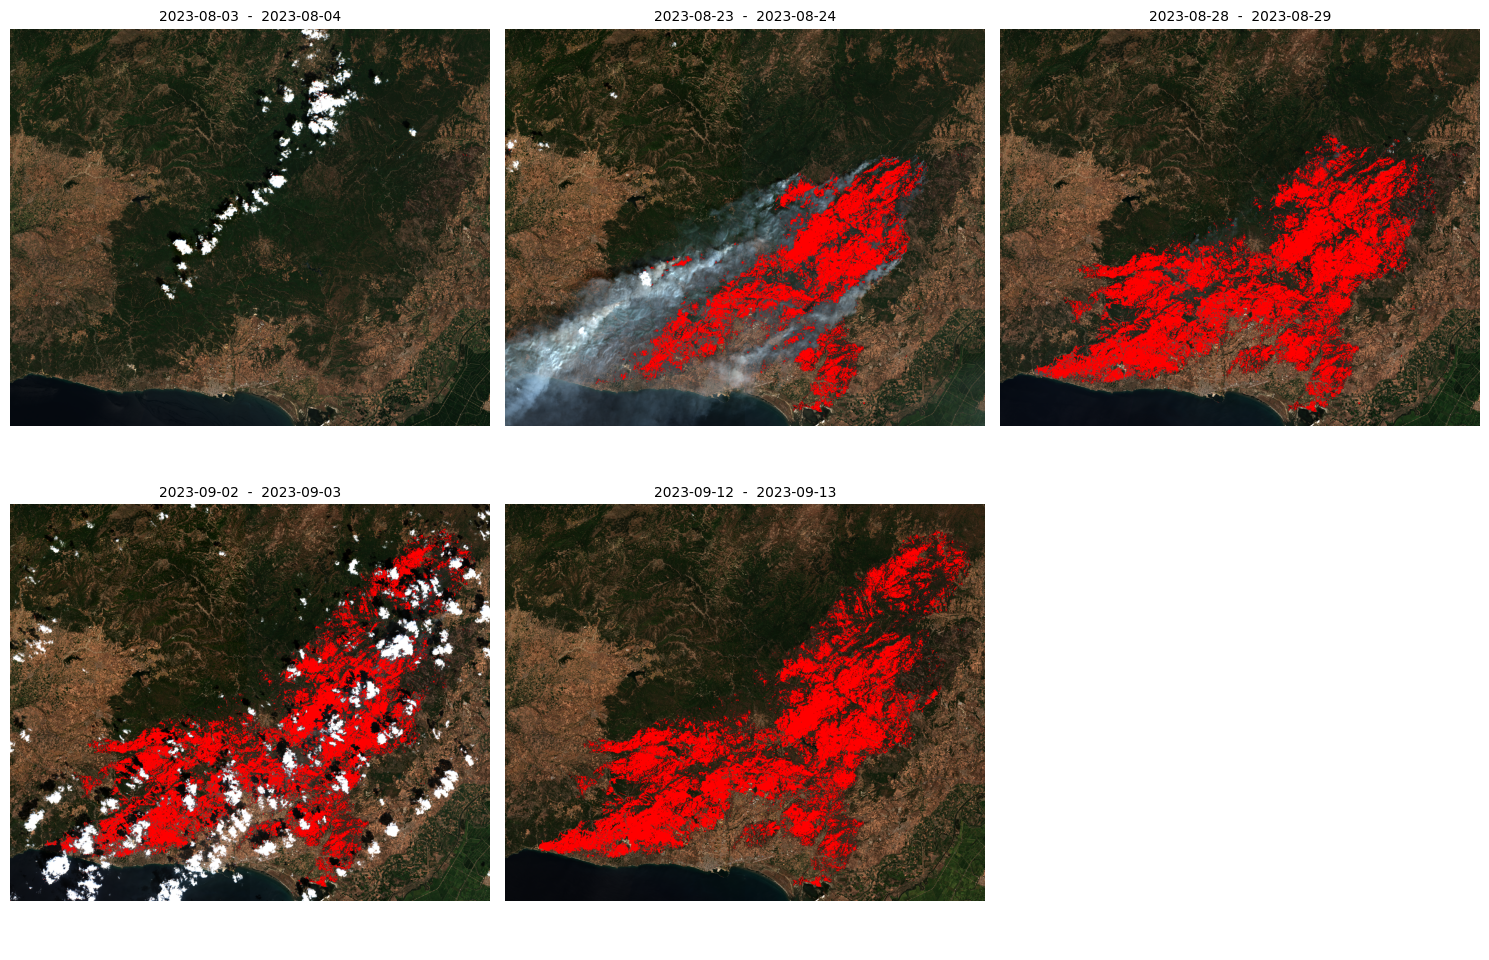

In [13]:
ncols = 3
nrows = 2
aspect_ratio = 1000 / 1000
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, slot in enumerate(slots):
    img = plt.imread(f"wildfire_{slot[0]}/default.tif")
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(img)
    ax.set_title(f"{slot[0]}  -  {slot[1]}", fontsize=10)

plt.tight_layout()

We make a similar visualization with the binary mask that represents the burnt area.

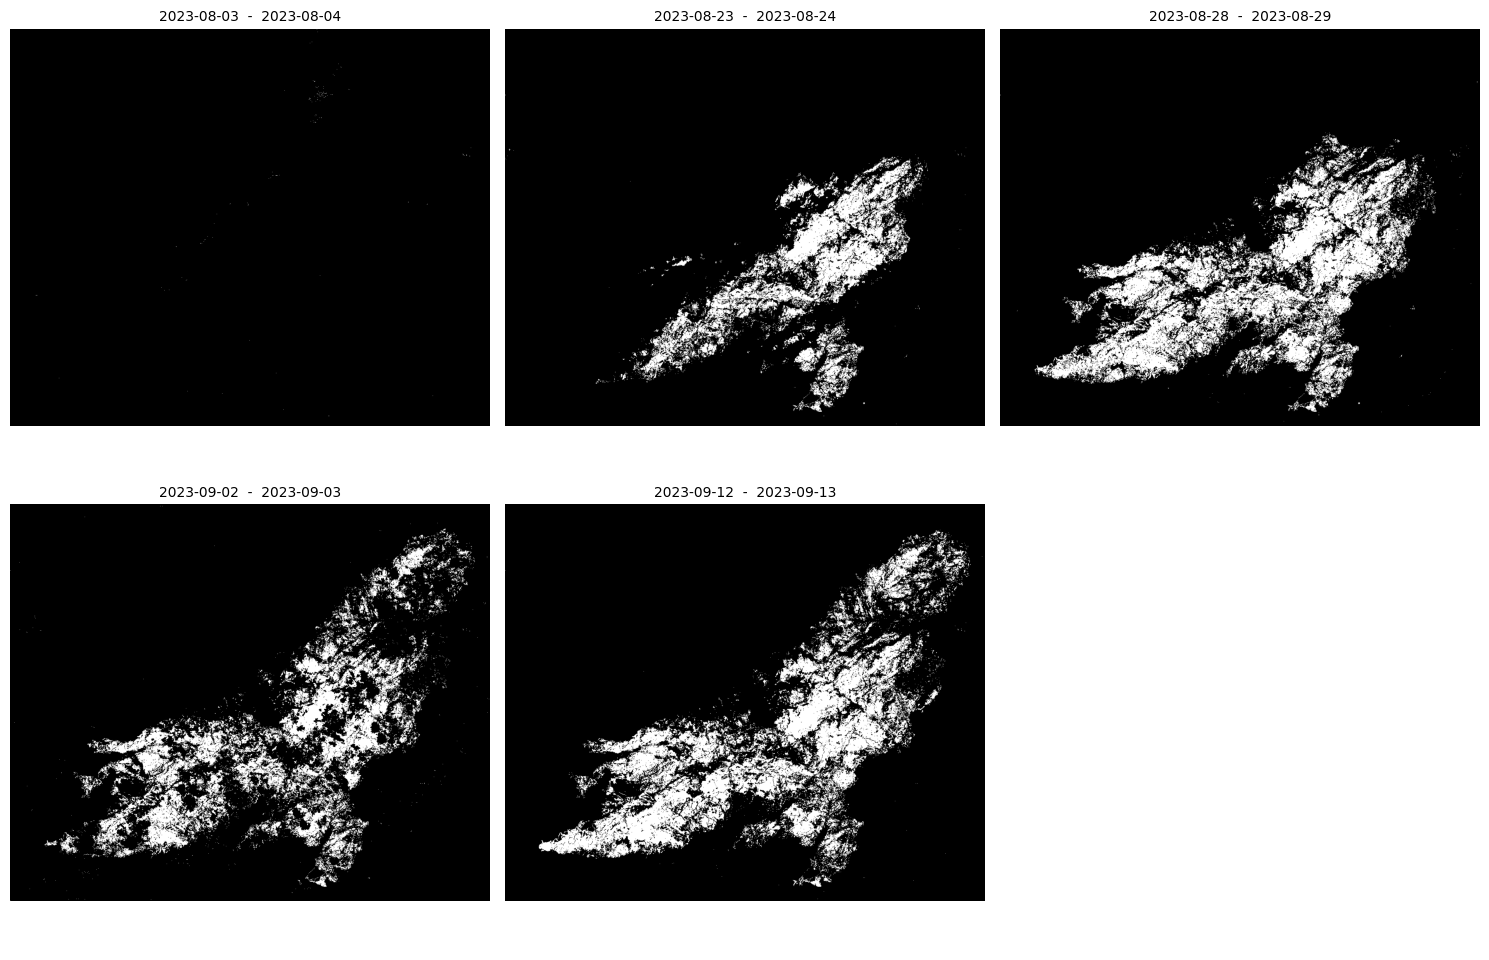

In [14]:
ncols = 3
nrows = 2
aspect_ratio = 1000 / 1000
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, slot in enumerate(slots):
    img = plt.imread(f"wildfire_{slot[0]}/burnMask.tif")
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{slot[0]}  -  {slot[1]}", fontsize=10)

plt.tight_layout()

To calculate the burnt area in square meters, we perform a simple count of the pixels labelled as burnt area. From the binary burnMask, we can define a function that calculates the number of pixels that have been classified as burnt regions and multiplies this by the resolution to get the area. The next cell runs this function that takes the mask and the resolution (in meters) as the input and outputs the total area for each time slot.

In [ ]:
def burnt_area(burnMask, resolution):
    burn_pixel_count = np.sum(burnMask)
    burnt_area = burn_pixel_count * (resolution * resolution) / 1000000

    return burnt_area

In [ ]:
burnt_area_arr = []
for idx, slot in enumerate(slots):
    burnMask = plt.imread(f"wildfire_{slot[0]}/burnMask.tif")
    burnt_area_arr.append(burnt_area(burnMask, resolution=50))
    print(
        f"The total burnt area is approximately {round(burnt_area(burnMask,resolution = 50),1)} km\u00b2"
    )

We can visualise the increasing damaged area by plotting these burnt pixels on a simple line chart as shown below.

In [ ]:
xlabels = [slot[0] for slot in slots]
x = range(len(slots))
plt.plot(range(len(slots)), burnt_area_arr)
plt.title("Time Series of area burnt in the wildfires.")
plt.xticks(np.arange(0, 5, step=1), xlabels, rotation=30, ha="center")
plt.xlabel("Time slots")
plt.ylabel("Area burnt (in $km^2$)")
plt.show()

## Summary

This was a brief guide on how to go from viewing satellite imagery in the Copernicus Browser using [Custom Scripts](https://custom-scripts.sentinel-hub.com/custom-scripts/) and requests from the [Requests Builder](https://shapps.dataspace.copernicus.eu/requests-builder/) to preparing a Jupyter Notebook to begin your analysis. From here, you can analyse the pixels, derive statistics and create a workflow that is suitable for your problem. The next step could be to familiarize yourself with various other Sentinel Hub API-s, using [this notebook example](https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/introduction_to_SH_APIs.ipynb). You can find more information about the different APIs and various examples in the [documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub.html). Check out the [Custom Scripts Repository](https://custom-scripts.sentinel-hub.com/custom-scripts/) for more examples of evalscripts for a wide range of applications. 